# INSTALL: packages

In [21]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\rankl\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [22]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\rankl\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [10]:
import os
import pickle
#from ipynb.fs.full.new_WalletClustering_MIH_fast import iterMultiInputClustering
from WalletClustering_MIH import iterMultiInputClustering_chunks
from graphviz import Digraph
import pandas as pd

# EXECUTE: WalletClustering_AddressIdentification notebook

In [ ]:
%run WalletClustering_AddressIdentification.ipynb # also includes running WalletClustering_neo4jConnect notebook
# methods & variables of notebook can be referenced

# DEFINE: Make graph of flows

## create blacklist of associations

In [11]:
def createAssocBlacklist():
    # use existing assocBlacklist if exists
    if not os.path.exists('output\\assocBlacklist.pickle'):
        assocBlacklistDf = pickle.load(open('output\\blacklistAddresses.pickle', 'rb'))
        assocBlacklistDf = assocBlacklistDf.drop_duplicates('association', keep='first')
        assocBlacklist = assocBlacklistDf['association'].tolist()

        with open('output\\assocBlacklist.pickle', 'wb') as export:
            pickle.dump(set(assocBlacklist), export)

    assocBlacklist = pickle.load(open('output\\assocBlacklist.pickle', 'rb'))

    # this line is necessary to fix unhashable type list in assocBlacklistCheck function
    # See here: http://net-informations.com/python/iq/unhashable.htm
    tuple_assocBlacklist = tuple(assocBlacklist)
    return tuple_assocBlacklist


## check for blacklisted association

In [12]:
#check if association is part of blacklisted associations
def assocBlacklistCheck(association, assocBlacklist):
    if association in assocBlacklist:
        return True
    else:
        return False

## query for input address association

In [13]:
def getAssoc(address):
    # return association of input address
    assocTemplate = '''
    MATCH (a:Address {address: "%s"})
    RETURN a.association
    '''

    association = conn.query(assocTemplate % address, db='neo4j')
    
    if association[0][0] is None:
        # run MI heuristic on address and query again
        addresses, association = iterMultiInputClustering_chunks(address) #should also flag new association in neo4J
        return association

    else:
        assocBlacklist = createAssocBlacklist()
        if assocBlacklistCheck(association, assocBlacklist):
            #throw exception in case association is blacklisted
            raise Exception('Blacklist')
        else:
            return association[0][0]

getAssoc("1348ThkNoDupq1bws95diMiL8haGs61K7M")

'YdMaeT9z9LUl3d2kaKvKuwCBhxnlKh3Z'

## gather input and output addresses to association

In [14]:
def get_Inputs(query_Input):
    response = conn.query(query_Input, db='neo4j')
    rows_list = []
    for record in response:
        dict1 = {}
        new_row = {'InputAddresses':record[0]._properties["address"],
        'Value_Received_from_Inp':record[1], 'Value_Send_from_Inp':record[2], 
        'Transaction_ID':record[3], 'Association':record[4]}
        dict1.update(new_row)
        rows_list.append(dict1)
    input_df = pd.DataFrame(rows_list) 
    return input_df  

In [15]:
def get_Outputs(query_Output):
    response = conn.query(query_Output, db='neo4j')
    rows_list = []
    for record in response:
        dict1 = {}
        new_row = {'Output_Addresses':record[0]._properties["address"],
        'Value_send_to_Outp':record[1], 'Value_rec_from_Outp':record[2],
        'Transaction_ID':record[3], 'Association':record[4]}
        dict1.update(new_row)
        rows_list.append(dict1)
    output_df = pd.DataFrame(rows_list) 
    return output_df

In [16]:
#get all addresses and their associations that are either output or input to an association (user)
def getInputs_Outputs(association):
    
    query_for_Outputs = """
    Match (a:Address {association: "%s"})-[send:SENDS]->(t:Transaction)-[r:RECEIVES]->(out:Address)
    return out as Output_Addresses, send.value as Value_send_to_Outp,r.value as Value_rec_from_Outp,
     t.txid as Transaction_ID, out.association as Association"""

    userOutput = get_Outputs(query_for_Outputs % association)

    query_for_Inputs = """
    Match (input:Address)-[s:SENDS]->(t:Transaction)-[r:RECEIVES]->(a:Address {association: "%s"})
    return input as Input_Addresses, r.value as Value_Received_from_Inp,s.value as Value_Send_from_Inp,
    t.txid as Transaction_ID, input.association as Association"""

    
    userInput = get_Inputs(query_for_Inputs % association)

    return userOutput, userInput

## query for input and output address asociations

['iLm67R8GEIeSjj1drSyimSOzhQAGxvPV', 'AEct34Ei6JL7Ci19Z3QoMji50KpjBtC2', 'tDpjijTwy39Hqt2tjNZHN0vMtgf49mE3', '7WRWfNC5XdSsc6gGrPaehrHACD97hr7U', 'tDpjijTwy39Hqt2tjNZHN0vMtgf49mE3', '7WRWfNC5XdSsc6gGrPaehrHACD97hr7U']


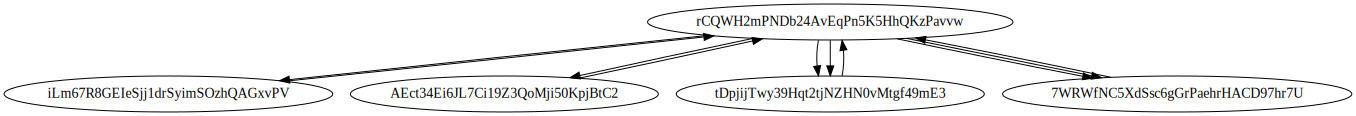

In [18]:
def buildFlowGraph(inputAddress):
    try:
        association = getAssoc(inputAddress)
    except:
        raise Exception('FU') # adjust to use case

    outputs, inputs = getInputs_Outputs(association)
    #print(outputs)
   
    outputAssocs = []
    for index, o in outputs.iterrows():
        if o['Association'] is not None:
            outputAssocs.append(o['Association'])
        else:
           outputAssocs.append(getAssoc(o['Output_Addresses']))
    print(outputAssocs)
    
    inputAssocs = []
    for index, i in outputs.iterrows():
        if i['Association'] is not None:
            inputAssocs.append(i['Association'])
        else:
            inputAssocs.append(getAssoc(i['Input_Addresses']))
    inputAssocs = set(inputAssocs)

    # build graph (adjust to use case)
    dot = Digraph()
    dot.node(association, association)
        
    for outNode in outputAssocs:
        dot.node(outNode, outNode)
        dot.edge(association, outNode)

    for inNode in inputAssocs:
        dot.node(inNode, inNode)
        dot.edge(inNode, association)
        
    return dot
buildFlowGraph("13Pcmh4dKJE8Aqrhq4ZZwmM1sbKFcMQEEV")
# 1AzBbi1iRsSWUkektm8KnuAvPx66JRtE4N gehört zu dem Silkroad Darknet Market :O

## include transaction information in graph

In [15]:
def getUserTransactionData(association, outputNodes, inputNodes):
    userOutputTransactionDataTemplate = '''
        MATCH (u:Address{association:"%s"})-[:SENDS]->(t:Transaction)-[:SENDS]->(o:Address{association:"%s"}),
        (u:Address)-[:SENDS]->(t:Transaction)-[:SENDS]->(o:Address)
        RETURN DISTINCT o
        ''' 

# RUN: Make graph of flows

In [16]:
inputAddress = ''
getAssoc("12sDU3FyYJXc2oRzE6XXuuhVHCBJvaoCC8")
getInputs_Outputs("yYiOdGN2a2TGR8GBwrMtk1CkMAFUcaan")

In [17]:
graph = buildFlowGraph(inputAddress)
graph.render(view=True)

Exception: FU